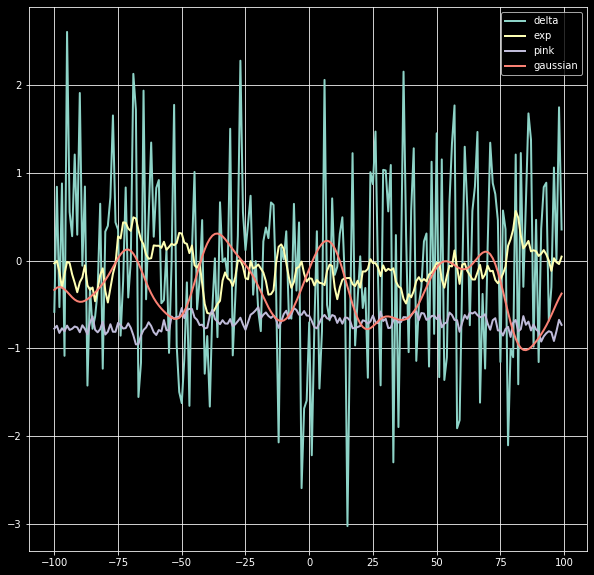

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import ffmpeg
import os
import glob
from turbolence1d import *

# test the correlated noise generation
M = 200
x = np.linspace(-M/2, M/2, num=M, endpoint=False)
eps = 0.002
plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 10))
# phase space plot
plt.grid(True)
plt.plot(x, random_field(M, C='delta'), linewidth=2, label='delta')
plt.plot(x, random_field(M, C='exp', eps=eps), linewidth=2, label='exp')
plt.plot(x, random_field(M, C='pink', eps=eps), linewidth=2, label='pink')
plt.plot(x, random_field(M, C='gaussian', eps=eps), linewidth=2, label='gaussian')
plt.legend()
plt.show()

In [10]:
# create the directory tree if not existent
basepath = './output/'
figspath = 'plots/'
videopath = 'video/'
try:
    os.mkdir(basepath)
except OSError:
    print("Failed creating output directory")
try:
    os.mkdir(basepath+figspath)
    os.mkdir(basepath+videopath)
except OSError:
    print("Failed creating directories")

# make mp4 from sequence of frames using ffmpeg
def make_video(fname, sim='pers'):
    try:
        os.remove(basepath+videopath+fname+'_'+sim+'.mp4')
    except FileNotFoundError:
        pass
    try:
        (
            ffmpeg
            .input(basepath+figspath+sim+'_*.png', pattern_type='glob', framerate=1)
            .output(basepath+videopath+fname+'_'+sim+'.mp4')
            .run()
        )
    except:
        print("Failed to generate the video")
        pass
    try:
        os.remove(basepath+figspath+sim+'_*.png')
    except:
        print("Failed to remove temporary figures")
        pass

Failed creating output directory
Failed creating directories


In [21]:
def init():
    L = 2000 # discrete sites
    N = 10000 # tracers
    tmax = 50
    nbins = int(np.sqrt(N)) # bins for the histogram
    assert(nbins>=1)

    eps = 1. / L
    dt = 0.001
    tau = 0.01 # inertial timescale,  Re ~ tau * L * std(u) [almost laminar flow?]

    # initial data for the odes
    v = 10 * random_field(N) # gaussian velocity distribution
    x = [int(i * L / N) for i in range(N)] # positions are uniform (deterministic)

    # plot parameterseps
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    main = [left, bottom, width, height]
    v_hist = [left + width + spacing, bottom, 0.2, height]
    x_hist = [left, bottom + height + spacing, width, 0.2]
    
    # progress bar
    status = 'Progress: [----------]'
    prog_idx = 11
    
    return L, N, tmax, nbins, eps, dt, tau, x, v, main, v_hist, x_hist, status, prog_idx

##  Case 1: $\delta(t)$-correlated velocity field

In [22]:
L, N, tmax, nbins, eps, dt, tau, x, v, main, v_hist, x_hist, status, prog_idx = init()

for t in range(tmax):
    u = 100 * random_field(L, C='gaussian', eps=eps)
    x, v = leapfrog_step(x, v, u, dt, tau, eps, L)
    scaled_x = [eps * x[i] for i in range(N)]
    # generate frames
    fname = 'delta_{:04d}.png'.format(t)    
    #
    fig = plt.figure(figsize=(10, 10))
    # phase space plot
    axc = fig.add_axes(main)
    axc.set_ylim(-2.5,2.5)
    axc.set_xlim(0, L * eps)
    xlab = 'tracer position (periodic)'
    xinfo ='\ntracers = {:d}, dt={:2.1e}, inertial ts={:2.1e}, spacing={:2.1e}'.format(N, dt, tau, eps)
    axc.set(xlabel=xlab+xinfo, ylabel='tracer speed')
    axc.plot(scaled_x,v, ',', )
    axc.ticklabel_format(axis='x', style='sci', scilimits=(0,-3), useOffset=True)
    # spatial distribution
    axu = fig.add_axes(x_hist)
    axu.set_xlim(0, L * eps)
    axu.hist(scaled_x, bins=nbins, density=True)
    axu.tick_params(axis="x", labelbottom=False)
    axu.set_yscale('log')
    axu.set(title='Phase-space and marginal distributions at t={:2.1e}'
            .format(t * dt))
    # velocity distribution
    axr = fig.add_axes(v_hist)
    axr.hist(v, bins=nbins, orientation='horizontal', density=True)
    axr.tick_params(axis="y", labelleft=False)
    axr.set_ylim(-2,2)
    axr.ticklabel_format(axis='x', style='sci', scilimits=(0,-3), useOffset=True)
    fig.savefig(basepath+figspath+fname)
    plt.close(fig)
    # progress bar
    if t == 0 or np.mod(t+1, (tmax/10)) == 0:
        if t != 0:
            status = status[:prog_idx] + '*' + status[prog_idx+1:]
            prog_idx += 1
        print('\r'+status+' {:d}%'.format(int((t+1) / tmax * 100)),  end="")
print()

make_video('1dturb', sim='delta')

Progress: [**********] 100%
Failed to remove temporary figures


## Case 2: persistent velocity field

In [23]:
L, N, tmax, nbins, eps, dt, tau, x, v, main, v_hist, x_hist, status, prog_idx = init()

u = 100 * random_field(L, C='gaussian', eps=eps)

for t in range(tmax):
    x, v = leapfrog_step(x, v, u, dt, tau, eps, L)
    scaled_x = [eps * x[i] for i in range(N)]
    # generate frames
    fname = 'pers_{:04d}.png'.format(t)    
    #
    fig = plt.figure(figsize=(10, 10))
    # phase space plot
    axc = fig.add_axes(main)
    axc.set_ylim(-2.5,2.5)
    axc.set_xlim(0, L * eps)
    xlab = 'tracer position (periodic)'
    xinfo ='\ntracers = {:d}, dt={:2.1e}, inertial ts={:2.1e}, spacing={:2.1e}'.format(N, dt, tau, eps)
    axc.set(xlabel=xlab+xinfo, ylabel='tracer speed')
    axc.plot(scaled_x, v, ',' )
    axc.ticklabel_format(axis='x', style='sci', scilimits=(0,-3), useOffset=True)
    # spatial distribution
    axu = fig.add_axes(x_hist)
    axu.set_xlim(0, L * eps)
    axu.hist(scaled_x, bins=nbins, density=True)
    axu.tick_params(axis="x", labelbottom=False)
    axu.set_yscale('log')
    axu.set(title='Phase-space and marginal distributions at t={:2.1e}'
            .format(t * dt))
    # velocity distribution
    axr = fig.add_axes(v_hist)
    axr.hist(v, bins=nbins, orientation='horizontal', density=True)
    axr.tick_params(axis="y", labelleft=False)
    axr.set_ylim(-2,2)
    axr.ticklabel_format(axis='x', style='sci', scilimits=(0,-3), useOffset=True)
    fig.savefig(basepath+figspath+fname)
    plt.close(fig)
    # progress bar
    if t == 0 or np.mod(t+1, (tmax/10)) == 0:
        if t != 0:
            status = status[:prog_idx] + '*' + status[prog_idx+1:]
            prog_idx += 1
        print('\r'+status+' {:d}%'.format(int((t+1) / tmax * 100)),  end="")
print()

make_video('1dturb', sim='pers')

Progress: [**********] 100%
Failed to remove temporary figures


In [ ]:
from IPython.display import HTML

HTML("""
    <video alt="turbolence" controls>
        <source src="ouput/video/1dturb.mp4" type="mp4">
    </video>
""")
